Shelley's coefficients (for cold temperatures):

$6.1078 \times exp \left( \frac{17.08085 T_a}{234.175 + T_a} \right)$

(Murray, 1967?)

Lawrence:

$610.94 \times exp \left( \frac{17.625 T_a}{243.04 + T_a} \right)$

In [1]:
import sys, re, glob
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs
from fs.sshfs import SSHFS
import imp

In [2]:
# from uv - login with ``ssh uvp`` (remote ssh port forwarding)
sshfs = SSHFS('localhost', 'arno', port=9000)

In [3]:
plots = imp.new_module('plots')
with sshfs.open('/home/arno/Documents/code/python/plots.py') as f:
    exec(f.read(), plots.__dict__)
    
IGRA = imp.new_module('IGRA')
with sshfs.open('/home/arno/Documents/code/python/data/IGRA.py') as f:
    exec(f.read(), IGRA.__dict__)

In [4]:
%matplotlib nbagg

In [6]:
with sshfs.open('/home/arno/Documents/data//IGRA/igra2-station-list.txt') as f:
    ista = IGRA.Monthly.read_stations(f).query('lat<=-60')

<IPython.core.display.Javascript object>


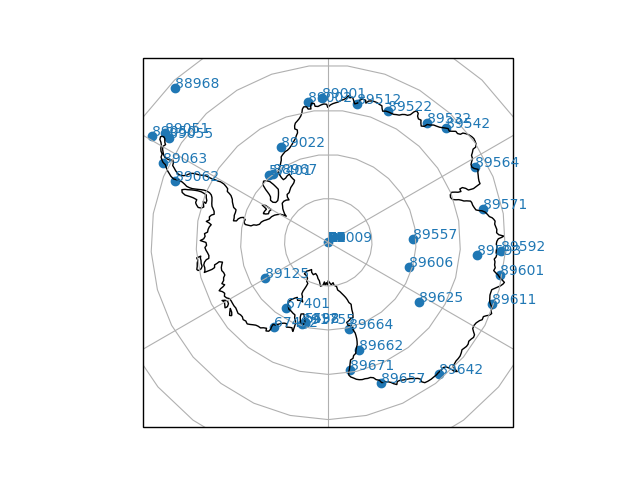

In [7]:
plt.figure()
ax = plt.subplot(1, 1, 1, projection=crs.SouthPolarStereo())
plots.annotated(ista[['lon', 'lat']])

In [112]:
# extract all levels
RH = []
DP = []
for f in glob.glob('data/Antarctica/*-data.txt.zip'):
    n = int(re.search('\d+', f).group())
    d = IGRA.extract(f).reset_index().pivot_table(index='datetime', columns='p')
    d = d[d.index>='1975']
    rh = d['RH'].dropna(0, 'all')
    dp = d['DPDP'].dropna(0, 'all')
    t = d['TEMP'].dropna(0, 'all')
    if rh.shape[0] > 0:
        RH.append((n, rh, t))
    if dp.shape[0] > 0:
        DP.append((n, dp, t))

In [58]:
# extract only the surface records
L = {}
for f in glob.glob('data/Antarctica/*-data.txt.zip'):
    D = {}
    n = int(re.search('\d+', f).group())
    d = IGRA.extract(f).reset_index().pivot_table(index='datetime', columns='p')
    x = d['RH'][d['LVLTYP2']==1].dropna(1, 'all')
    if x.dropna(0, 'all').any().any():
        p = x.columns.values.reshape((1, -1)) * x.notnull().astype(int) # note that this produces 0 instead of nan
        D['rh'] = x.sum(1)
        D['p'] = p.sum(1).to_frame()
        
    x = d['DPDP'][d['LVLTYP2']==1].dropna(1, 'all')
    if x.dropna(0, 'all').any().any():
        p = x.columns.values.reshape((1, -1)) * x.notnull().astype(int)
        D['dpdp'] = x.sum(1)
        if 'p' in D:
            D['p'] = p.sum(1).to_frame().combine_first(D['p'])
        else:
            D['p'] = p.sum(1).to_frame()
        
    x = d['TEMP'][d['LVLTYP2']==1].dropna(1, 'all')
    if x.dropna(0, 'all').any().any():
        p = x.columns.values.reshape((1, -1)) * x.notnull().astype(int)
        D['temp'] = x.sum(1)
        if 'p' in D:
            D['p'] = p.sum(1).to_frame().combine_first(D['p'])
        else:
            D['p'] = p.sum(1).to_frame()
    
    x = d['GPH'][d['LVLTYP2']==1].dropna(1, 'all')
    if x.dropna(0, 'all').any().any():
        p = x.columns.values.reshape((1, -1)) * x.notnull().astype(int)
        D['GPH'] = x.sum(1)
        if 'p' in D:
            D['p'] = p.sum(1).to_frame().combine_first(D['p'])
        else:
            D['p'] = p.sum(1).to_frame()  
    L[n] = pd.concat(D, 1)

In [59]:
n, df = zip(*L.items())

In [21]:
da = IGRA.surface(glob.glob('data/Antarctica/*-data.txt.zip'))

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/dtypes.py:25: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  elif np.issubdtype(dtype, int):
/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/dtypes.py:29: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif np.issubdtype(dtype, complex):


In [43]:
IGRA.mixing_ratio(da)

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [45]:
da.to_netcdf('data/Antarctica/surface.nc')

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/conventions.py:861: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(inferred_dtype, float):


In [85]:
def trim(x):
    x.columns = x.columns.droplevel(1)
    return xr.DataArray(x)

d = xr.concat([trim(x) for x in df], pd.Index(n, name='station'))
ds = d.to_dataset(dim='dim_1')
ds.to_netcdf('data/Antarctica/surface_p_temp_dpdp_rh.nc')

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [56]:
import gc
gc.collect()

585

In [115]:
nr, rh, t1 = zip(*RH)
r = xr.concat([xr.DataArray(g) for g in rh], pd.Index(nr, name='station'))
nd, dp, t2 = zip(*DP)
d = xr.concat([xr.DataArray(g) for g in dp], pd.Index(nd, name='station'))

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [116]:
nr

(88968, 89055, 88967, 89009, 89125)

In [117]:
nd

(88968, 89002, 89062, 89055, 89022, 88967, 89009, 89050)

In [128]:
t3 = list(t2)

In [130]:
t3.extend(t1[-1:])

In [132]:
nt = list(nd)

In [134]:
nt.extend(nr[-1:])

In [136]:
t = xr.concat([xr.DataArray(g) for g in t3], pd.Index(nt, name='station'))

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [137]:
ds = xr.Dataset({'rh': r, 'dpdp': d, 'temp': t})
ds.to_netcdf('data/Antarctica/temp_dpdp_rh_stations.nc')

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [14]:
def replace_nan(x, value=-8888., fact=0.1):
    v = x.values.copy()
    v[v==value] = np.nan
    return xr.DataArray(v * fact, coords=x.coords)

In [66]:
ds = xr.open_dataset('data/Antarctica/temp_dpdp_rh_stations.nc')

In [8]:
ds = xr.open_dataset('data/Antarctica/surface_p_temp_dpdp_rh_w.nc')

In [20]:
d

,p,LVLTYP1,LVLTYP2,ETIME,PFLAG,GPH,ZFLAG,TEMP,TFLAG,RH,DPDP,WDIR,WSPD
datetime,,,,,,,,,,,,,
1957-04-05 12:00:00,85000.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,170.0
1957-04-05 12:00:00,70000.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,288.0
1957-04-05 12:00:00,50000.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,268.0
1957-04-05 12:00:00,30000.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,170.0
1957-04-05 12:00:00,20000.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,306.0,144.0
1957-04-05 12:00:00,15000.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,285.0,46.0
1957-04-05 12:00:00,10000.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,267.0,103.0
1957-04-05 12:00:00,5000.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.0,201.0
1957-04-06 12:00:00,85000.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,267.0,113.0


In [48]:
def mixing_ratio(df):
    d = df.reset_index(level='p').replace(-8888., np.nan)
    t = d['TEMP'] / 10.
    p = d['p']

    # dewpoint (dewpoint depression dpdp = temp - dewpt)
    dewp = (t - d['DPDP'] / 10.)

    # vapor pressure (saturation vapor pressure at dewpoint temperature)
    e = 610.94 * np.exp(17.625 * dewp / (243.04 + dewp))

    # mixing ratio
    w_dp = 0.622 * e / (p - e)

    # saturation vapor pressure
    es = 610.94 * np.exp(17.625 * t / (243.04 + t))

    e = es * d['RH'] / 1000 # rh in tenths as everything except pressure

    w_rh = 0.622 * e / (p - e)

    w = pd.concat((p, w_dp, w_rh, d['LVLTYP2']), 1)
    w.columns = ['p', 'dp', 'rh', 'LVLTYP2']
    return w.loc[w[['rh', 'dp']].notnull().any(1)]

In [59]:
rh = []
for s in w_rh.station:
    t = w_rh.sel(station=s).dropna('datetime').datetime
    if len(t) > 0:
        rh.append((s.item(), len(t), t.values[0], t.values[-1]))
dp = []
for s in w_dp.station:
    t = w_dp.sel(station=s).dropna('datetime').datetime
    if len(t) > 0:
        dp.append((s.item(), len(t), t.values[0], t.values[-1]))

In [61]:
pd.DataFrame(rh)

,0,1,2,3
0,88968,8322,1957-07-01 00:00:00,1985-12-31 12:00:00
1,57401,2138,1957-03-15 18:00:00,1962-11-30 12:00:00
2,89055,4509,1982-07-06 12:00:00,2018-01-17 12:00:00
3,89022,13402,1957-07-01 12:00:00,2018-01-26 12:00:00
4,88967,1660,1970-06-11 00:00:00,1975-07-02 12:00:00
5,89009,25139,1961-01-01 00:00:00,2018-01-26 12:00:00
6,89063,3194,1956-01-01 15:00:00,1972-12-22 12:00:00
7,89125,7616,1957-03-23 03:00:00,1975-01-31 12:00:00
8,89051,1429,1969-03-03 12:00:00,1972-05-14 12:00:00
9,89001,1763,1957-07-01 12:00:00,1972-12-27 00:00:00


In [62]:
pd.DataFrame(dp)

,0,1,2,3
0,88968,8322,1957-07-01 00:00:00,1985-12-31 12:00:00
1,89002,10781,1984-05-03 12:00:00,2017-11-29 12:00:00
2,89062,2934,2002-01-07 12:00:00,2018-01-26 12:00:00
3,89055,4509,1982-07-06 12:00:00,2018-01-17 12:00:00
4,89022,13402,1957-07-01 12:00:00,2018-01-26 12:00:00
5,88967,1660,1970-06-11 00:00:00,1975-07-02 12:00:00
6,89009,25139,1961-01-01 00:00:00,2018-01-26 12:00:00
7,89063,3194,1956-01-01 15:00:00,1972-12-22 12:00:00
8,89125,7616,1957-03-23 03:00:00,1975-01-31 12:00:00
9,89051,1429,1969-03-03 12:00:00,1972-05-14 12:00:00


<IPython.core.display.Javascript object>


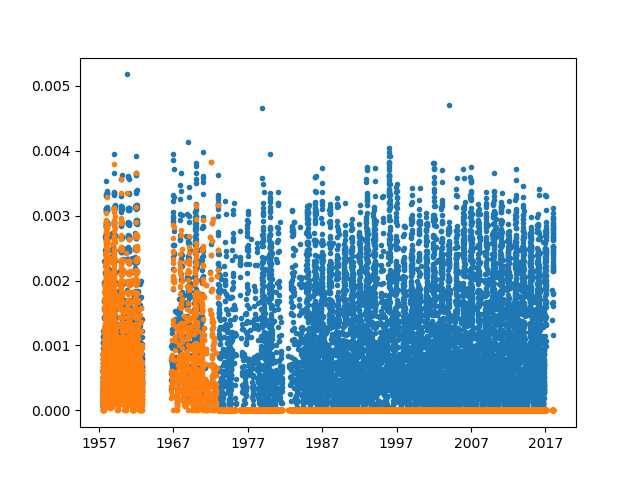

In [96]:
plt.figure()
pl = plt.plot(w_dp.datetime, w_dp.sel(station=89022), '.')
pl = plt.plot(w_rh.datetime, w_rh.sel(station=89022), '.')

<IPython.core.display.Javascript object>


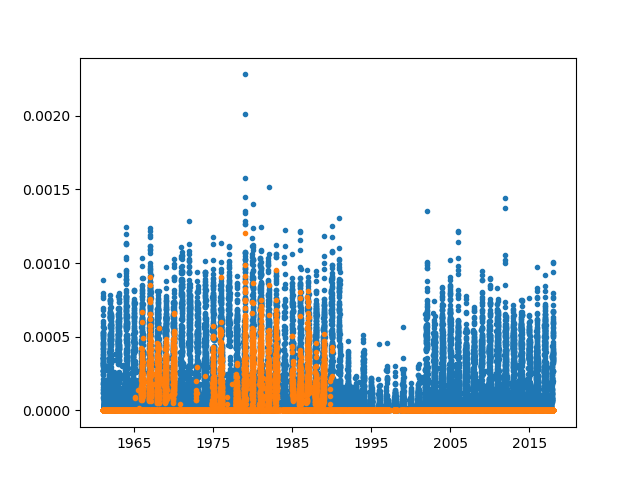

In [97]:
plt.figure()
pl = plt.plot(w_dp.datetime, w_dp.sel(station=89009), '.')
pl = plt.plot(w_rh.datetime, w_rh.sel(station=89009), '.')

In [5]:
b = xr.open_dataset('data/Antarctica/temp_dpdp_rh_stations.nc')

In [9]:
b.sel(station=89022).datetime.min()

<xarray.DataArray 'datetime' ()>
array('1975-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    station  int64 89022

In [5]:
df = IGRA.Raw.extract('data/Antarctica/AYM00089022-data.txt.zip')

In [8]:
w = xr.open_dataarray('data/Antarctica/w_from_dpdp.nc')

In [9]:
a = w.sel(station=89022).dropna('datetime', 'all')

In [32]:
def vertint(a):
    b = pd.DataFrame(a.values, index=a.datetime, columns=a.p).fillna(axis=1, method='ffill')
    p = a.p.values.reshape((1, -1)).repeat(len(a.datetime), 0)
    na = a.isnull().values
    p[na] = np.nan
    p = pd.DataFrame(p, index=a.datetime, columns=a.p)
    dp = p.fillna(axis=1, method='ffill').diff(1, 1)
    dp.values[na] = np.nan
    bsum = b.values[:, :-1] + b.values[:, 1:]
    s = np.nansum(dp.values[:, 1:] * bsum, 1) / 2
    return pd.Series(s, index=a.datetime), dp

In [ ]:
def vertint(w, mixing_ratio='dp', pressure='p'):
    b = w[[pressure, mixing_ratio]].pivot(columns='p').fillna(axis=1, method='ffill')
    p = b.columns.get_level_values('p').values.reshape((1, -1)).repeat(b.shape[0], 0)
    na = b.isnull().values
    p[na] = np.nan
    p = pd.DataFrame(p, index=b.index, columns=b.columns)
    dp = p.fillna(axis=1, method='ffill').diff(1, 1)
    dp.values[na] = np.nan
    bsum = b.values[:, :-1] + b.values[:, 1:]
    s = np.nansum(dp.values[:, 1:] * bsum, 1) / 2
    return pd.Series(s, index=a.datetime), dp

In [59]:
b = w[['p','dp']].pivot(columns='p').fillna(axis=1, method='ffill')

In [65]:
na = b.isnull()

In [72]:
p = b.columns.get_level_values('p').values.reshape((1, -1)).repeat(b.shape[0], 0)

In [74]:
p

(14538, 1901)

<IPython.core.display.Javascript object>


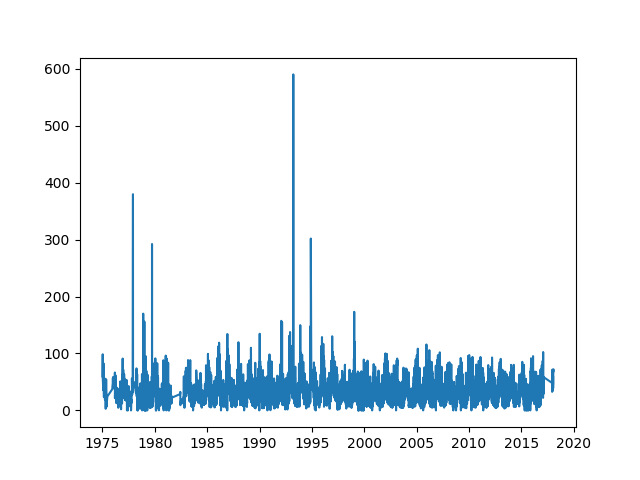

In [230]:
plt.figure()
plt.plot(s)

<IPython.core.display.Javascript object>


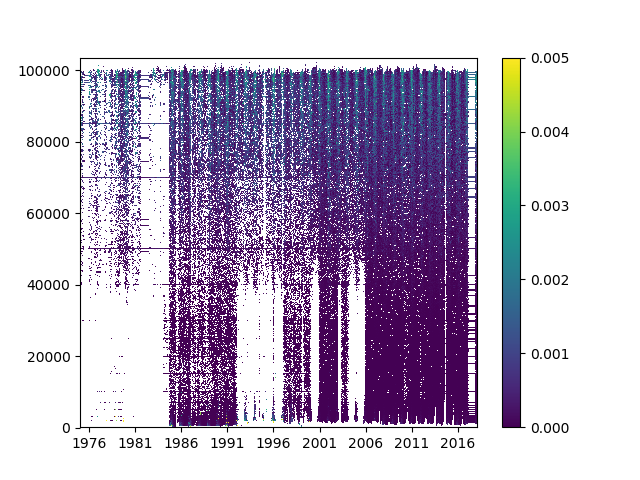

In [100]:
plt.figure()
plt.pcolormesh(a.datetime, a.p, a.T, vmin=0, vmax=.005)
plt.colorbar()

<IPython.core.display.Javascript object>


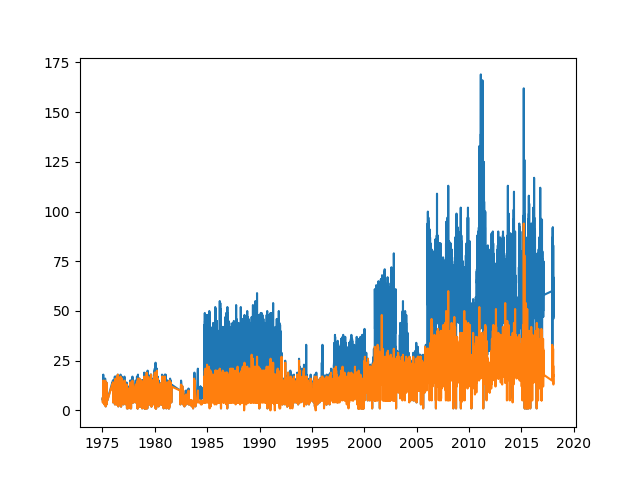

In [95]:
plt.figure()
plt.plot(a.datetime, a.notnull().sum('p'))
plt.plot(a.datetime, a.sel(p=slice(50000, None)).notnull().sum('p'))

In [46]:
sfc = xr.open_dataset('data/Antarctica/surface.nc')

In [47]:
w_rh = sfc['w_rh'].sel(station=89022).dropna('datetime', 'all')
w_dp = sfc['w_dp'].sel(station=89022).dropna('datetime', 'all')

<IPython.core.display.Javascript object>


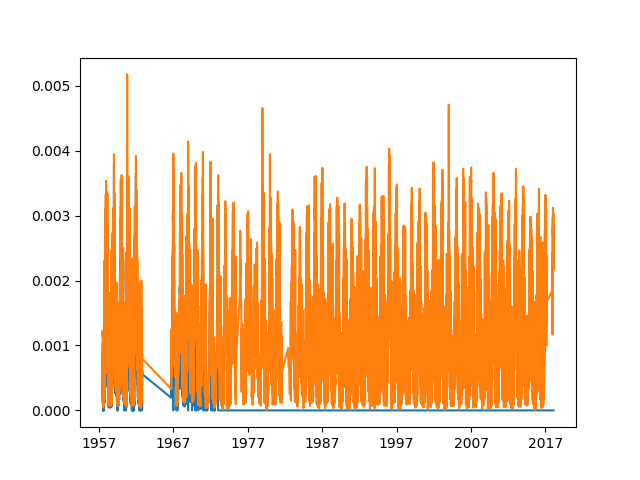

In [24]:
plt.figure()
plt.plot(w_rh.datetime, w_rh)
plt.plot(w_dp.datetime, w_dp)

In [49]:
w = mixing_ratio(df)

In [50]:
sfc = w[w['LVLTYP2']==1]

<IPython.core.display.Javascript object>


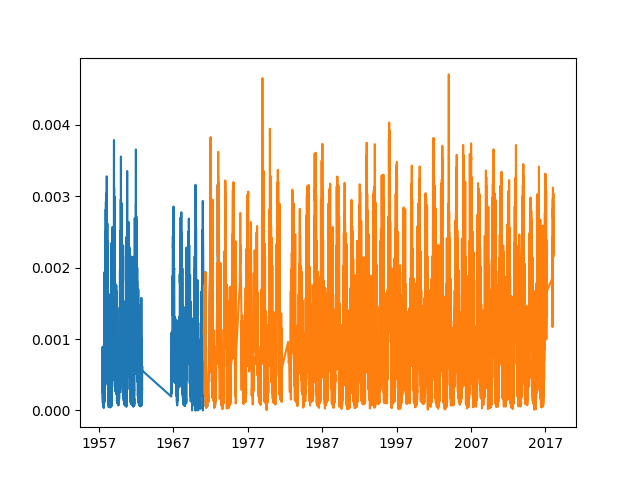

In [51]:
plt.figure()
plt.plot(sfc['rh'])
plt.plot(sfc['dp'])

<IPython.core.display.Javascript object>


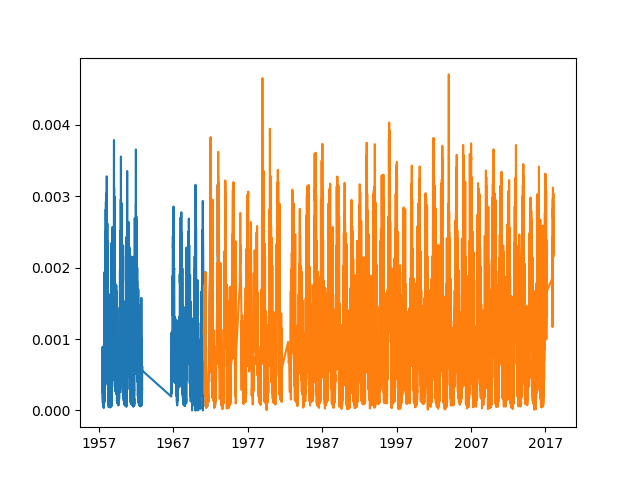

In [52]:
plt.figure()
plt.plot(w_rh.datetime, w_rh)
plt.plot(w_dp.datetime, w_dp)

In [50]:
sfc.sel(station=89022)['GPH'].mean()

<xarray.DataArray 'GPH' ()>
array(27.31193)
Coordinates:
    station  int64 89022

In [51]:
sfc.sel(station=89022)['p'].mean()

<xarray.DataArray 'p' ()>
array(98442.999073)
Coordinates:
    station  int64 89022

<IPython.core.display.Javascript object>


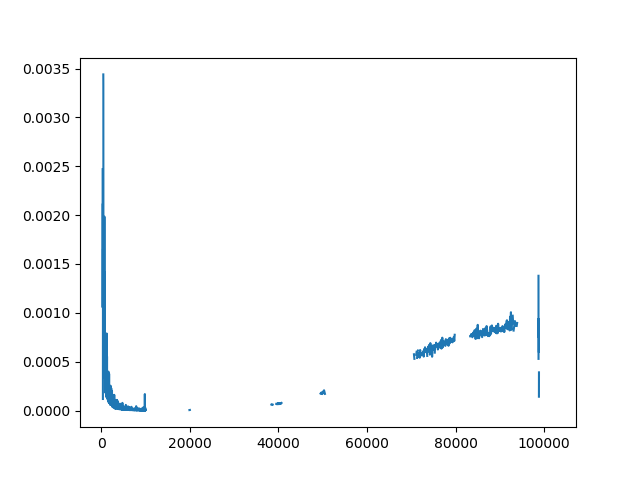

In [43]:
plt.figure()
plt.plot(a.p, a.mean('datetime'))

In [33]:
s, dp = vertint(a)

<IPython.core.display.Javascript object>


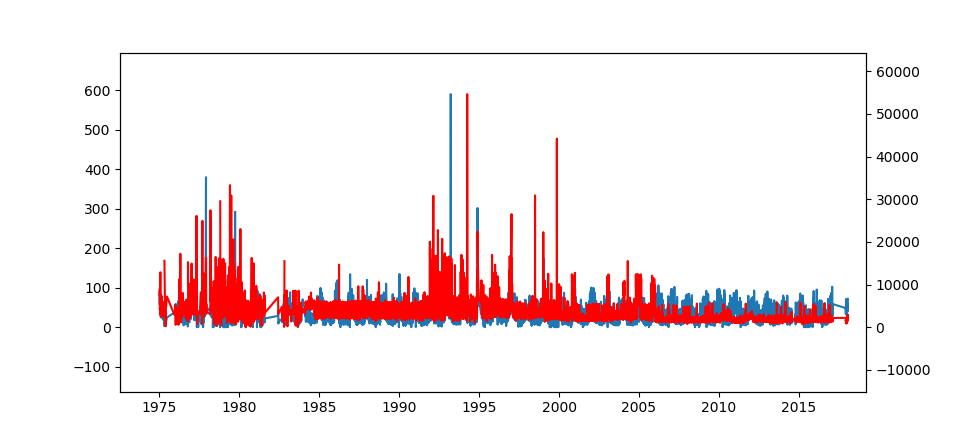

In [40]:
fig, ax = plt.subplots()
plt.plot(s)
bx = ax.twinx()
plt.plot(dp.index, dp.std(1), 'r')

In [2]:
sys.path.append('/sata1_ceazalabs/arno/HPC/uvHome/code/python')
import mpicdf
from ipyparallel import Client
rc = Client(profile='mpi')
view = rc[:]
view.activate() # <- activate magics
view.block = True
# view.block = False
view.run('/sata1_ceazalabs/arno/HPC/uvHome/code/python/parallel.py')

<AsyncResult: execute:finished>

In [49]:
ds2.to_netcdf('data/Antarctica/w_from_dpdp.nc')

In [5]:
%px data = mpicdf.Data('w_from_dpdp.nc', var='w', dim='station')

In [21]:
%px data.x.squeeze().shape

(37255, 6235)

(37255, 6235)

(37255, 6235)

(37255, 6235)

(37255, 6235)

(37255, 6235)

(37255, 6235)

In [22]:
%px mask = ~data.x.squeeze().mask

In [61]:
%px c, idx = np.unique(mask, axis=0, return_inverse=True)

In [88]:
%px c.sum(1).max()

20

171

118

56

69

82

169

In [87]:
%px c.shape

(1562, 6235)

(12403, 6235)

(2940, 6235)

(5943, 6235)

(4410, 6235)

(10931, 6235)

(11182, 6235)

In [84]:
%%px
for i, m in enumerate(c):
#     x = data.x.squeeze()[idx==i+1, :][:, m]
    print(sum(m))

KeyboardInterrupt: 

In [52]:
sta = pd.HDFStore('data/Antarctica/stations.h5')

In [55]:
sta['sta'].columns

Index(['COMP', 'Height', 'Latitude', 'Longitude', 'MISC', 'Name', 'PRCP',
       'SKY', 'SUN', 'TEMP', 'WATER', 'WIND', 'WXTYPE', 'datacoverage',
       'elevation', 'elevationUnit', 'id', 'latitude', 'longitude', 'maxdate',
       'mindate', 'name', 'type'],
      dtype='object')